In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.dataloader
from torchvision import datasets
import matplotlib.pyplot as plt

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "bird"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "bird.zip", "wb") as f:
        request = requests.get("https://www.kaggle.com/api/v1/datasets/download/veeralakrishna/200-bird-species-with-11788-images")
        print("Downloading data...")
        f.write(request.content)

     #Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "bird.zip", "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(image_path)

Did not find data/bird directory, creating one...
Unzipping data...


In [ ]:
!tar -xzvf "/content/data/bird/CUB_200_2011.tgz" -C "/content/data/bird/"


attributes.txt
CUB_200_2011/
CUB_200_2011/images/
CUB_200_2011/images/001.Black_footed_Albatross/
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0032_796115.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0057_796106.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0036_796127.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0060_796076.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0019_796104.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0069_796139.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0089_796069.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0071_796113.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0077_796114.jpg
CUB_200_2011/images/001.Black_footed_Albat

In [ ]:
!tar -xzvf "/content/data/bird/segmentations.tgz" -C "/content/data/bird/"

In [ ]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path/"CUB_200_2011/images")

In [ ]:
def data_Loader(image_data,batch_size):
  BirdDataSet=datasets.ImageFolder(image_data,transform=transforms.Compose([transforms.Resize((224,224)),
                                                                            transforms.ToTensor()]))
  train_len=int(0.70 * len(BirdDataSet))
  test_len=int(len(BirdDataSet)- train_len)
  #print(len(BirdDataSet),train_len)
  train_data,test_data= torch.utils.data.random_split(BirdDataSet, [train_len, test_len])
  train_d=torch.utils.data.dataloader.DataLoader(train_data,batch_size=batch_size,shuffle=True)
  test_d=torch.utils.data.dataloader.DataLoader(test_data,batch_size=batch_size,shuffle=True)
  return train_d, test_d

In [ ]:
train_dataloader, test_dataloader = data_Loader("/content/data/bird/CUB_200_2011/images/",32)
train_dataloader
classes=datasets.ImageFolder("/content/data/bird/CUB_200_2011/images/").classes
classes

In [ ]:
train_iter = iter(train_dataloader)
test_iter = next(iter(test_dataloader))
image, label = train_iter.__next__()
image.shape, label.shape
image=image.permute(0,2,3,1)
plt.imshow(image[0],cmap="gray")
plt.title(classes[label[0]])


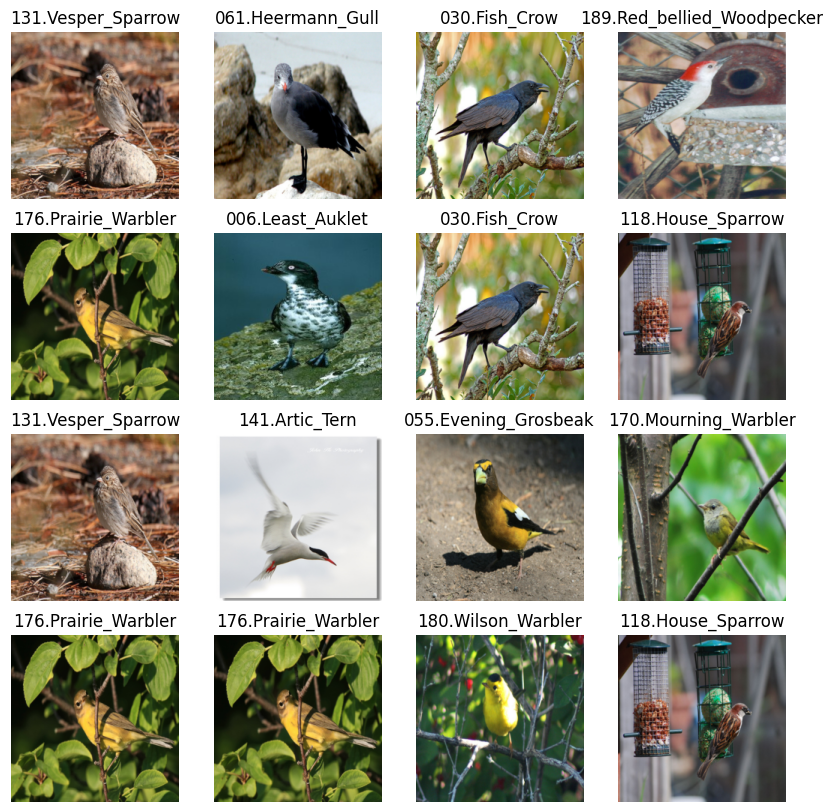

In [ ]:
fig=plt.figure(figsize=(10,10))
torch.manual_seed(42)

rows,cols=4,4
for i in range(1,rows*cols+1):
  index=torch.randint(0,32,size=[1]).item()
  img= image[index]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(classes[label[index]])
  plt.axis(False)


In [ ]:
class block(nn.Module):
  def __init__(self,input_shape:int, output_shape:int, identity=None, stride=1 ):
    super().__init__()
    self.expansion=4
    self.conv1=nn.Conv2d(in_channels=input_shape,out_channels=output_shape,kernel_size=1,padding=0,stride=1)
    self.norm1=nn.BatchNorm2d(output_shape)
    self.conv2=nn.Conv2d(in_channels=output_shape,out_channels=output_shape,kernel_size=3,padding=1,stride=stride)
    self.norm2=nn.BatchNorm2d(output_shape)
    self.conv3=nn.Conv2d(in_channels=output_shape,out_channels=output_shape* self.expansion,kernel_size=1,padding=0,stride=1)
    self.norm3=nn.BatchNorm2d(output_shape*self.expansion)
    self.relu=nn.ReLU()
    self.identity=identity

  def forward(self,x):
    id=x
    x=self.conv1(x)
    x=self.norm1(x)
    x=self.relu(x)
    x=self.conv2(x)
    x=self.norm2(x)
    x=self.relu(x)
    x=self.conv3(x)
    x=self.norm3(x)
    if self.identity is not None:
      id=self.identity(id)
    x+=id
    x=self.relu(x)
    return x

class Resnet(nn.Module):
  def __init__(self,block,layers,image_channels,num_classes):
    super().__init__()
    self.in_channels=64
    self.conv1=nn.Conv2d(in_channels=image_channels,out_channels=64,kernel_size=7,stride=2,padding=3)
    self.norm1=nn.BatchNorm2d(64)
    self.relu=nn.ReLU()
    self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

    self.layer1=self.make_layer(block,layers[0],64,stride=1)
    self.layer2=self.make_layer(block,layers[1],128,stride=2)
    self.layer3=self.make_layer(block,layers[2],256,stride=2)
    self.layer4=self.make_layer(block,layers[3],512,stride=2)

    self.avgpool=nn.AdaptiveAvgPool2d((1,1))
    self.fc=nn.Linear(512*4,num_classes)

  def forward(self,x):
     x=self.conv1(x)
     x=self.norm1(x)
     x=self.relu(x)
     x=self.maxpool(x)

     x=self.layer1(x)
     x=self.layer2(x)
     x=self.layer3(x)
     x=self.layer4(x)

     x=self.avgpool(x)
     x=x.reshape(x.shape[0],-1)
     x=self.fc(x)
     return x



  def make_layer(self,block,remaining_blocks,output_shape,stride):
    identity_downsample=None
    layers=[]

    if stride!=1 or self.in_channels!=output_shape*4:
      identity_downsample=nn.Sequential(nn.Conv2d(in_channels=self.in_channels,out_channels=output_shape*4,kernel_size=1,stride=stride),
                                        nn.BatchNorm2d(output_shape*4))
    layers.append(block(self.in_channels,output_shape,identity_downsample,stride))
    self.in_channels=output_shape*4

    for i in range(remaining_blocks-1):
      layers.append(block(self.in_channels,output_shape))

    return nn.Sequential(*layers)


def Resnet50(im_channels=3,num_classes=len(classes)):
  return Resnet(block, [3,4,6,3],im_channels,num_classes)


In [ ]:
model1=Resnet50()
image2=image.permute(0,3,1,2)
image2.shape

torch.Size([32, 3, 224, 224])

In [ ]:
model1

Resnet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model1.parameters(),lr=0.01)

In [ ]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("Already downloaded...")
else:
  print("Downloading...")
  request=requests.get(url="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

Already downloaded...


In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc=0,0

  model.train()

  for batch, (X,y) in enumerate(data_loader):
    X,y=X.to(device),y.to(device)

    y_preds= model(X)

    loss=loss_fn(y_preds,y)
    train_loss+=loss
    train_acc+=accuracy_fn(y_true=y,y_pred=y_preds.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss/=len(data_loader)
  train_acc/=len(data_loader)
  print(f"Train Loss: {train_loss:.4f} || Train Accuracy: {train_acc:.4f}%")

In [ ]:
def test_step(model:torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device:torch.device=device):
  test_loss=0
  test_acc=0

  model.eval()
  with torch.inference_mode():
    for X_test,y_test in data_loader:

      X_test,y_test=X_test.to(device),y_test.to(device)
      y_test_preds=model(X_test)

      test_loss+=loss_fn(y_test_preds,y_test)
      test_acc+=accuracy_fn(y_true=y_test,y_pred=y_test_preds.argmax(dim=1))

    test_loss/=len(data_loader)
    test_acc/=len(data_loader)

    print(f"Test Loss: {test_loss:.2f} || Test Accuracy: {test_acc:.2f}%")

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=3

for epoch in tqdm(range(epochs)):
  #print(f"Epoch: {epoch}\n----")

  train_step(model=model1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model1,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)


  0%|          | 0/3 [00:00<?, ?it/s]